** Before running this notebook, run the 2 cells containing supporting functions at the bottom. **

# Daily Fantasy Sports and Quantitative Finance
### A case study on using quantitative finance tools to build daily fantasy sports lineups.


Daily fantasy sports (DFS) have emerged in recent years as a popular skill game. Usually, games challenge participants to pick a team of players (called a 'lineup') in a particular sport on a given day with the objective of getting the most game points on that day. In the classic DFS format, players are assigned a fictional 'salary' or cost and the DFS participant has to pick a roster of players who fit under a total cost constraint, commonly referred to as a 'salary cap'. Players are ranked at the end of the day based on a sport-dependent scoring function.

In this notebook, we will take a look at how quantitative finance tools can be used to study daily fantasy sports data and build an optimal lineup using convex optimization. Specifically, we will take a look at the NBA (basketball) game on DraftKings. The data used in this notebooks is obtained from https://stats.nba.com and [DraftKings](https://www.draftkings.com) (DK). The tools used are a mix of tools from the Quantopian API as well as other Python libraries.

## Load and Format Data
The first step to most quantitative problems is to get data. In this study, the data was collected and uploaded to the Quantopian research environment as a .csv file. Let's load it into a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) using [local_csv](https://www.quantopian.com/help#quantopian_research_local_csv) (a Quantopian-specific function).

In [2]:
import pandas as pd

In [3]:
df = local_csv('nba_data.csv')

In [4]:
df['game_datetime'] = pd.to_datetime(df['game_date'])

In [5]:
df = df.set_index(['game_datetime', 'player_id'])

It is important to know what our data looks like, so here is a preview of the first few rows of our DataFrame.

In [6]:
df.head(3)

,,game_id,season_id,game_date,matchup,wl,min,fgm,fga,fg_pct,fg3m,...,height,weight,birth_date,age,exp,school,dk_score,dk_salary,dk_position,dk_position_codes
game_datetime,player_id,,,,,,,,,,,,,,,,,,,,,
2018-04-11,1713,21701230,22017,2018-04-11,SAC vs. HOU,W,25,5,8,0.625,2,...,6-6,220,"JAN 26, 1977",41.0,19,North Carolina,17.75,NaN,NaN,NaN
2018-04-09,1713,21701210,22017,2018-04-09,SAC @ SAS,L,17,1,2,0.500,1,...,6-6,220,"JAN 26, 1977",41.0,19,North Carolina,14.50,NaN,NaN,NaN
2018-04-06,1713,21701188,22017,2018-04-06,SAC @ MEM,W,13,0,4,0.000,0,...,6-6,220,"JAN 26, 1977",41.0,19,North Carolina,9.75,3400.0,SG/SF,"[0, 1, 0, 1, 0, 1, 1, 1]"


And here is a look at a single row where we can see all of the columns.

In [7]:
df.iloc[10]

game_id                              21701057
season_id                               22017
game_date                          2018-03-19
matchup                           SAC vs. DET
wl                                          L
min                                        17
fgm                                         3
fga                                         6
fg_pct                                    0.5
fg3m                                        1
fg3a                                        4
fg3_pct                                  0.25
ftm                                         0
fta                                         0
ft_pct                                      0
oreb                                        1
dreb                                        0
reb                                         1
ast                                         0
stl                                         2
blk                                         1
tov                               

## Alphalens (Factor Analysis)
[Alphalens](https://github.com/quantopian/alphalens) is a tool on Quantopian for analyzing the predictve ability of a factor. In this notebook, we will use Alphalens to analyze the predictive ability of a **fantasy points per game** factor.

The first step to analzing our factor is to define it. Here, we will define the fantasy points per game factor, `trailing_20_dk_score` to be the rolling mean fantasy points per game (using DK scoring rules) over the last 20 days.

In [8]:
# Rolling 20 day mean fantasy score per game.
trailing_20_dk_score = df['dk_score'].unstack().shift(1).rolling(20, min_periods=5).mean().stack()

In [14]:
trailing_20_dk_score.head()

game_datetime  player_id
2017-10-26     1717         20.10
               2037         20.70
               2199         22.40
               2207         15.50
               2544         55.95
dtype: float64

And then we need to define our objective metric, or 'what we want to maximize'. In finance, we want to maximize portfolio returns. In DraftKings DFS, we want to maximize our DraftKings score for the current day.

In [11]:
# DK scores.
scores = df['dk_score'].unstack()

Next, we need to import Alphalens so that we can use it to analyze our factors.

In [12]:
import alphalens as al

Before using Alphalens, we need to format our data in a way that it expects. Let's start with our points factor. The below function creates a DataFrame using our points factor and our DK scores. It also specifies `periods` to be 1, meaning we only care about the performance of the player on one day. The data will be categorized into 5 'quantiles' to remove some of the noise from the relationship.

Now, let's plot the relationship between each of our points per game factor quantiles and see how strongly they predict DK points on a given day.

In [13]:
# Format rolling fantasy points per game data for use in Alphalens.
factor_data = get_clean_factor_and_forward_scores(
    factor=trailing_20_dk_score,
    scores=scores.loc['2017-11-09':],
    periods=[1],
)

In [14]:
mean_by_q_daily, std_err_by_q_daily = al.performance.mean_return_by_quantile(factor_data,
                                                                                       by_date=True,
                                                                                       demeaned=False)

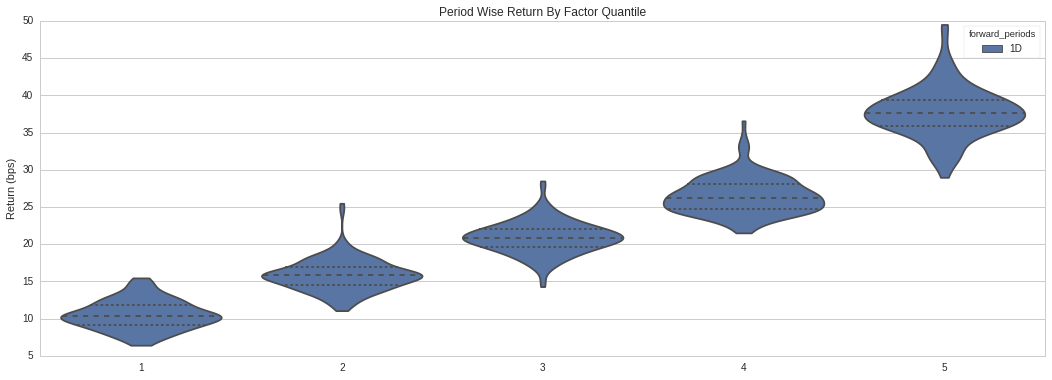

In [15]:
al.plotting.plot_quantile_returns_violin(mean_by_q_daily/10000);

It looks like our fantasy points per game factor is a strong predictor. We see a  narrow and distinct distribution around each quantile's mean DK points (y axis).

Let's look at another visualization of the points per game factor and plot out the daily mean of each quantile.

In [16]:
quant_spread, std_err_spread = al.performance.compute_mean_returns_spread(mean_by_q_daily,
                                                                                 upper_quant=5,
                                                                                 lower_quant=1,
                                                                                 std_err=std_err_by_q_daily)

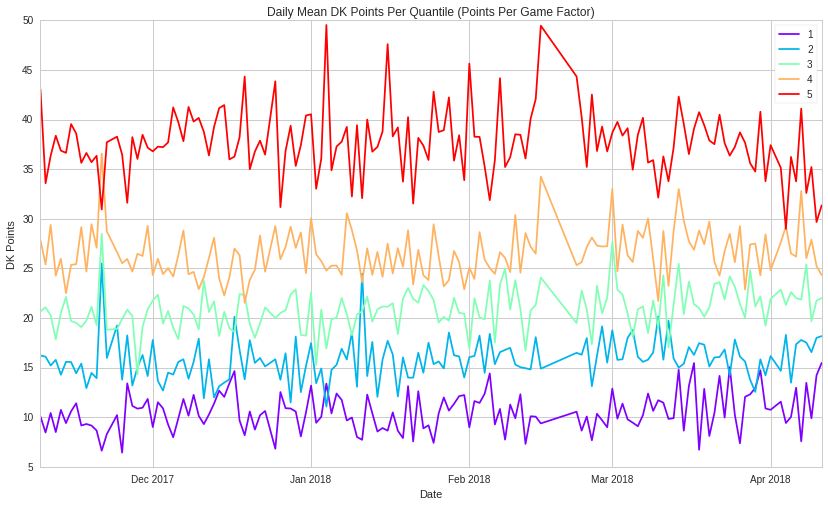

In [17]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
quantiles = mean_by_q_daily.index.get_level_values(0)
colors = cm.rainbow(np.linspace(0, 1, len(quantiles.unique())))
for quantile in quantiles.unique():
    x = mean_by_q_daily[quantiles == quantile].index.get_level_values(1)
    y = mean_by_q_daily[quantiles == quantile]
    plt.plot(x, y, color=colors[quantile-1])
    
ax = plt.gca()
ax.legend(quantiles.unique())
ax.set_ylabel('DK Points')
ax.set_xlabel('Date')

plt.title('Daily Mean DK Points Per Quantile (Points Per Game Factor)')

## Optimize (Portfolio Optimization)
Now that we have identified some strong predictors of fantasy points, let's use the data to build an optimal portfolio each day. Specifically, we will pick a team of players (construct a portfolio) based on their mean points per game over the last 20 days.

On Quantopian, we can use the [Optimize API](https://www.quantopian.com/help#optimize-title) to help us calculate an optimal 'portfolio' each day. In finance, this means picking the stocks that we should hold each day based on an objective function and a set of constraints. In daily fantasy sports, the problem is the same: we want to pick a lineup based on an objective function (maximize DK points) subject to a series of constraints (based on the rules of the game).

Generally speaking, constraints are the easy part. The rules are set before every game and we know that our lineup has to follow these rules. Specifically, the NBA game at DraftKings has the following [rules](https://www.draftkings.com/help/rules/4):
- The lineup must be composed of exactly 8 players.
- The sum of the fictional player salaries in a lineup must be less than 50,000.
- A lineup must include players from at least two NBA games.
- A lineup must include at least one player classified in each of the following positions:
    - PG
    - SG
    - PF
    - SF
    - C
    - G (PG or SG, in addition to the other PG and SG slots)
    - F (PF or SF, in addition to the other PF and SF slots)
    - U (the last spot can be occupied by a player of any position).
    
The challenging part is creating an objective function. We know that we want to maximize the number of DK points that we get on a given day, but without time travel, it's difficult to know exactly what the function looks like. In practice, this means we need to define an 'expected value' objective that represents our expected performance of each player. Earlier, we saw that our trailing points per game factor was a good predictor of DK points, so let's use that as our objective function.

As an optimization problem, this means that we want to pick a team of players subject to the DK rules (salary cap, positions, etc.) that maximizes the total trailing points per game factor.

Let's define our problem using the Optimize API.

In [18]:
# Import the Optimize namespace.
import quantopian.optimize as opt

Let's start by assembling and formatting the player salaries and positions so that we can use them as constraints in our optimization problem.

In [19]:
# Player costs.
player_costs = pd.DataFrame(df['dk_salary']).dropna().sort_index(level=['game_datetime', 'player_id'])

# Player positions.
player_positions = df['dk_position_codes'].dropna().apply((lambda x: [int(y) for y in x[1:-1].split(',')]))

Then, let's restructure our (`trailing_20_dk_score`) so that we can use it as an objective function in Optimize. We'll define it to be parametric on the date so that we can play around with the date later on.

In [20]:
# Define the game date that we want to test. Change this and re-run 
# cells below to build a lineup for another date.
TEST_DATE = '2017-12-01'

In [21]:
# Format our expected value factor (trailing_20_dk_score) for use in Optimize.
expected_value = trailing_20_dk_score[player_costs.index].dropna()
expected_value = expected_value[expected_value.index.get_level_values(0) == TEST_DATE]

### Objective
Next, let's define our objective function using [optimize.MaximizeAlpha](https://www.quantopian.com/help#quantopian_optimize_MaximizeAlpha), which will try to maximize the value of our lineup based on our `expected_value` factor.

In [22]:
# Objective function to be fed into Optimize later on.
obj = opt.MaximizeAlpha(expected_value)

### Constraints
Many of the built-in constraints are centered around finance problems, so we will have to make some simplifying assumptions in order to use them to build our lineup. Later in the notebook, we will build our own optimizer to build a lineup that strictly follows the DK rules.

Let's start by defining our salary cap constraint:

In [23]:
# Salary cap constraint. The total cost of our lineup has to be less than 50,000.
# We will define this as a FactorExposure constraint.
cost_limit = opt.FactorExposure(
    player_costs, 
    min_exposures={'dk_salary': 0}, 
    max_exposures={'dk_salary': 50000}
)

Next, we'll define a position constraint. To simplify things, we'll use more generic positions, and limit ourselves to a maximum of 4 forwards (`F`), 4 guards (`G`), and 2 centers (`C`), with a minimum of 3 `F`, 3 `G`, and 1 `C`.

In [24]:
# Map from each player to its position.
labels = df['position'].apply(lambda x: x[0])

# # Maps from each position to its min/max exposure.
min_exposures = {'F': 3, 'G': 3, 'C': 1}
max_exposures = {'F': 4, 'G': 4, 'C': 2}

player_position_constraint = opt.NetGroupExposure(labels, min_exposures, max_exposures)

At this point, it's worth noting that Optimize operates in weight space, meaning it chooses a percentage (not bounded by a total of 100%, can also be positive or negative) of the overall lineup to allocate to each asset/player. In an attempt to get around that, the next constraint we define will specify that we can hold no more than 1 of each player, and no fewer than 0 of each player (you can't [short sell](https://www.investopedia.com/terms/s/shortselling.asp) a player... yet).

In [25]:
# This constraints tells the Optimizer than we can hold at most 1 of each player
discretize_players = opt.PositionConcentration(
    pd.Series([]),
    pd.Series([]),
    default_min_weight=0,
    default_max_weight=1,
)

Lastly, let's define a constraint for our total number of players.

In [26]:
max_players = opt.MaxGrossExposure(8)

### Calculate Optimal Portfolio (Build Lineup)
The next step is to calculate our optimal portfolio for the day using our objective and constraints.

In [27]:
result = opt.calculate_optimal_portfolio(
    objective=obj,
    constraints=[
        discretize_players,
        player_position_constraint,
        max_players,
        cost_limit,
    ]
)

And here are the resulting weights:

In [28]:
resulting_picks = result[(result.index.get_level_values(0) == TEST_DATE)]
player_weights = resulting_picks[resulting_picks>0]

In [29]:
lineup_info = df.loc[player_weights.index][['matchup', 'player', 'position', 'dk_salary']]

In [30]:
lineup_info['weight'] = player_weights

In [31]:
lineup_info

matchup            player position  dk_salary  \
game_datetime player_id                                                      
2017-12-01    200768     TOR vs. IND        Kyle Lowry        G     8100.0   
              201188     MEM vs. SAS        Marc Gasol        C     7800.0   
              201988       SAS @ MEM       Patty Mills        G     4100.0   
              202331     OKC vs. MIN       Paul George        F     8200.0   
              202692     UTA vs. NOP        Alec Burks        G     3600.0   
              202710       MIN @ OKC      Jimmy Butler        G     7300.0   
              202711       IND @ TOR  Bojan Bogdanovic        F     4600.0   
              202734       NOP @ UTA     E'Twaun Moore      F-G     3600.0   
              203506       IND @ TOR    Victor Oladipo        G     8000.0   

                           weight  
game_datetime player_id            
2017-12-01    200768     1.000000  
              201188     1.000000  
              201988     1.000000  
              202331     1.000000  
              202692     0.459459  
              202710     0.540541  
              202711     1.000000  
              202734     1.000000  
              203506     1.000000

Something that immediately pops out is the non-binary weight assigned to Kemba Walker. Obviously, it's not possible to pick 0.55% of a player in DFS, so this lineup won't be eligible to enter. Unfortunately, it's not currently possible to binarize the outputs of Optimize on Quantopian (since it's not a helpful feature in quantitative finance).

# CVXPY
To get around the limits of Optimize, we can take a similar approach and use [cvxpy](http://www.cvxpy.org/en/latest/), a Python library for solving convex optimization problems (and the library on top of which Optimize was built), to build our own objective and constraints. In this version, we will follow the exact rules of the DraftKings NBA game (8 players, \$50k salary cap, players in at least two games, and one player in each of the following positions: ['PG', 'SG', 'PF', 'SF', 'C', 'G', 'F', 'U']. The following cells build constraints to enforce these rules.

In [32]:
# List of DK positions.
DK_POSITION_LIST = ['PG', 'SG', 'PF', 'SF', 'C', 'G', 'F', 'U']

In [36]:
# Get the average play time for all players over the last 20 games. We will use this to
# filter out players with skewed stats due to playing very little.
trailing_20_mins = df['min'].unstack().shift(1).rolling(20, min_periods=5).mean().stack()

In [37]:
# Players with non-null salary on TEST_DATE.
have_salary = player_costs[player_costs.index.get_level_values(0) == TEST_DATE].dropna().index

# Values from our factor for TEST_DATE.
trailing_dk_score_today = trailing_20_dk_score[
    (trailing_20_dk_score.index.get_level_values(0) == TEST_DATE)
]

# Players with at least 5 minutes per game on average over the last 20 days.
trailing_mins_today = trailing_20_mins[(trailing_20_mins.index.get_level_values(0) == TEST_DATE)]
have_play_time = trailing_mins_today[trailing_mins_today >= 5].index

# Eligible players for us to pick have a non-null salary and at least 5 minutes
# played per game over the last 20 days.
eligible_players_today = have_salary.intersection(have_play_time)

# The game ID in which each player is playing.
player_games = df.loc[eligible_players_today].game_id

# The set of all game IDs on TEST_DATE
todays_games = df.loc[eligible_players_today].game_id.unique().tolist()

Next, we will import cvxpy and define our objective and constraints.

In [38]:
import cvxpy as cvx

In [39]:
# Player salaries and expected values.
salaries = np.squeeze(np.array(player_costs.loc[eligible_players_today]))
values = np.array(expected_value[eligible_players_today])

# The variable we are solving for. We define our output variable as a Bool
# since we have to make a binary decision on each player (pick or don't pick).
selection = cvx.Bool(len(salaries))
selection.is_positive = new_is_positive

# Our lineup's total salary must be less than 50,000.
salary_cap = 50000
cost_constraint = salaries * selection <= salary_cap

# Our lineup must be composed of exactly 8 players.
player_constraint = np.ones(len(salaries)) * selection == 8

# Our total expected value is the sum of the value of each player in
# the lineup. We define our objective to maximize the total expected
# value.
total_expected_value = values * selection
objective = cvx.Maximize(total_expected_value)

# Put our cost and player count constraints in a list.
constraints = [cost_constraint, player_constraint]

# Define our position constraints. Positions are represented along an 8-element
# array corresponding to the positions in DK_POSITION_LIST.
position_min = np.array([1, 1, 1, 1, 1, 3, 3, 8])
pos_limits = {}
i = 0
for pos in DK_POSITION_LIST:
    pos_limits[pos] = np.array(player_positions[eligible_players_today].apply(lambda x: x[i]))
    constraints.append((pos_limits[pos] * selection) >= position_min[i])
    i += 1

# Define our game constraints. We rephrase the rule as 'you cannot pick more than
# 7 players from any one game'.
for gid in todays_games:
    game_limit = np.array(player_games == gid)
    constraints.append((game_limit * selection) <= 7)
    
    

# We tell cvxpy that we want maximize our expected value, subject to all
# of our constraints.
optimization_problem = cvx.Problem(objective, constraints)

print "Our total expected value from today's lineup is:"

# Solving the problem.
optimization_problem.solve(solver=cvx.ECOS_BB)

Our total expected value from today's lineup is:


273.37121208187256

Based on our player-by-player expected values and the constraints we supplied to `cvxpy`, our optimal lineup has a total expected value of 273.37.

Let's take a look at who is in this lineup to make sure that we implemented the rules properly:

In [40]:
# Format output and get relevant player info for display.
dk_team = pd.Series(np.squeeze(selection.value).tolist()[0])
player_info = df.loc[player_costs.loc[eligible_players_today].iloc[dk_team[dk_team > 0.1].index.values].index][['matchup', 'player', 'dk_position', 'dk_salary', 'dk_score']]

In [41]:
player_info

matchup          player dk_position  dk_salary  \
game_datetime player_id                                                       
2017-12-01    200768     TOR vs. IND      Kyle Lowry          PG     8100.0   
              201959       MIN @ OKC      Taj Gibson        PF/C     5700.0   
              202331     OKC vs. MIN     Paul George          SF     8200.0   
              202692     UTA vs. NOP      Alec Burks       PG/SG     3600.0   
              202710       MIN @ OKC    Jimmy Butler          SG     7300.0   
              203087       CHA @ MIA     Jeremy Lamb       SG/SF     5700.0   
              203506       IND @ TOR  Victor Oladipo       PG/SG     8000.0   
              1627832    TOR vs. IND   Fred VanVleet          PG     3400.0   

                         dk_score  
game_datetime player_id            
2017-12-01    200768        31.75  
              201959        16.00  
              202331        62.00  
              202692        35.75  
              202710        45.25  
              203087        24.50  
              203506        66.25  
              1627832       27.50

In [48]:
print "Total lineup salary: %d" % player_info['dk_salary'].sum()
print "Total actual score: %d" % player_info['dk_score'].sum()

Total lineup salary: 50000
Total actual score: 309


Our roster appears to satisfy the rules!

# Backtest (a.k.a. run the above code over several consecutive days)

In [42]:
def backtest(factor, dates, filters, df, player_costs, player_positions):
    historical_results = {}
    
    daily_expected_value = factor[filters].dropna()
    
    for _date in dates:
        try:
            print _date
            daily_filter = filters[filters.get_level_values(0) == _date]
            expected_value_today = daily_expected_value[daily_expected_value.index.get_level_values(0) == _date]

            # The game ID in which each player is playing.
            player_games = df.loc[daily_filter].game_id

            # The set of all game IDs on the current date.
            todays_games = df.loc[daily_filter].game_id.unique().tolist()

            # Player salaries and expected values.
            salaries = np.squeeze(np.array(player_costs.loc[daily_filter]))
            values = np.array(expected_value_today[daily_filter])

            # The variable we are solving for. We define our output variable as a Bool
            # since we have to make a binary decision on each player (pick or don't pick).
            selection = cvx.Bool(len(salaries))
            selection.is_positive = new_is_positive

            # Our lineup's total salary must be less than 50,000.
            salary_cap = 50000
            cost_constraint = salaries * selection <= salary_cap

            # Our lineup must be composed of exactly 8 players.
            player_constraint = np.ones(len(salaries)) * selection == 8

            # Our total expected value is the sum of the value of each player in
            # the lineup. We define our objective to maximize the total expected
            # value.
            total_expected_value = values * selection
            objective = cvx.Maximize(total_expected_value)

            # Put our cost and player count constraints in a list.
            constraints = [cost_constraint, player_constraint]

            # Define our position constraints. Positions are represented along an 8-element
            # array corresponding to the positions in DK_POSITION_LIST.
            position_min = np.array([1, 1, 1, 1, 1, 3, 3, 8])
            pos_limits = {}
            i = 0
            for pos in DK_POSITION_LIST:
                pos_limits[pos] = np.array(player_positions[daily_filter].apply(lambda x: x[i]))
                constraints.append((pos_limits[pos] * selection) >= position_min[i])
                i += 1

            # Define our game constraints. We rephrase the rule as 'you cannot pick more than
            # 7 players from any one game'.
            for gid in todays_games:
                game_limit = np.array(player_games == gid)
                constraints.append((game_limit * selection) <= 7)


            # We tell cvxpy that we want maximize our expected value, subject to all
            # of our constraints.
            knapsack_problem = cvx.Problem(objective, constraints)

            # Solving the problem.
            predicted_value = knapsack_problem.solve(solver=cvx.ECOS_BB)

            dk_team = pd.Series(np.squeeze(selection.value).tolist()[0])
            player_info = df.loc[player_costs.loc[filters].iloc[dk_team[dk_team > 0.1].index.values].index][['matchup', 'player', 'dk_position', 'dk_salary', 'dk_score']]
            historical_results[_date] = {
                'actual_score': player_info.dk_score.sum(),
                'expected_score': predicted_value,
            }
        except TypeError:
            pass
        except ValueError:
            pass
    
    return historical_results

In [45]:
test_dates = trailing_20_dk_score.index.get_level_values(0).unique().values[15:]
has_playtime = trailing_20_mins[trailing_20_mins >= 5]

In [46]:
filters = player_costs.index & has_playtime.index
backtest_result = backtest(
    trailing_20_dk_score,
    test_dates,
    filters,
    df,
    player_costs,
    player_positions,
)

2017-11-10T00:00:00.000000000
2017-11-11T00:00:00.000000000
2017-11-12T00:00:00.000000000
2017-11-13T00:00:00.000000000
2017-11-14T00:00:00.000000000
2017-11-15T00:00:00.000000000
2017-11-16T00:00:00.000000000
2017-11-17T00:00:00.000000000
2017-11-18T00:00:00.000000000
2017-11-19T00:00:00.000000000
2017-11-20T00:00:00.000000000
2017-11-21T00:00:00.000000000
2017-11-22T00:00:00.000000000
2017-11-24T00:00:00.000000000
2017-11-25T00:00:00.000000000
2017-11-26T00:00:00.000000000
2017-11-27T00:00:00.000000000
2017-11-28T00:00:00.000000000
2017-11-29T00:00:00.000000000
2017-11-30T00:00:00.000000000
2017-12-01T00:00:00.000000000
2017-12-02T00:00:00.000000000
2017-12-03T00:00:00.000000000
2017-12-04T00:00:00.000000000
2017-12-05T00:00:00.000000000
2017-12-06T00:00:00.000000000
2017-12-07T00:00:00.000000000
2017-12-08T00:00:00.000000000
2017-12-09T00:00:00.000000000
2017-12-10T00:00:00.000000000
2017-12-11T00:00:00.000000000
2017-12-12T00:00:00.000000000
2017-12-13T00:00:00.000000000
2017-12-14

actual_score      189.060714
expected_score    276.071713
dtype: float64


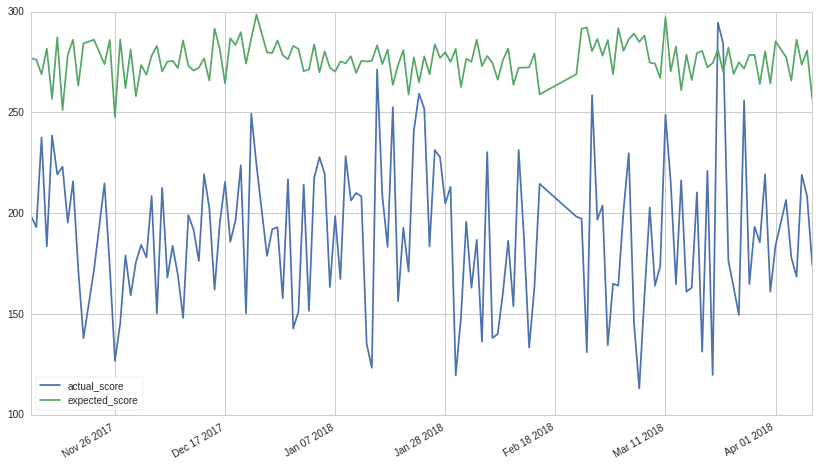

In [47]:
daily_results = pd.DataFrame.from_dict(backtest_result, orient='index')
print daily_results.mean()
daily_results.plot();

## Conclusion
In this notebook, we looked at daily fantasy sports using quantitative finance tools. We started out by pulling in and looking at NBA data. We created and tested the ability of certain statistics to predict DK points using Alphalens. We attempted to build an optimal lineup using Optimize. And lastly, we used cvxpy to build a proper solution to the daily lineup construction problem.

## Future Work
In both quantitative finance and daily fantasy sports, the hardest problem is forecasting results of an asset or player in the future. Now that we have a notebook built to help us test factors and build lineups, the next step is to iterate on ideas of predictive signals. In this example, we only looked at two relatively simple metrics (minutes played and points scored). It would be interesting to try new factors to see if they are predictive or provide a leg up on the competitiong.

Another area that we didn't explore in this notebook is risk. In most team sports, the measured statistics of one player tend to be correlated (positively or negatively) with other players in the game. For example, players might get fantasy points for getting an assist when a teammate scores. These correlations can be defined as risk factors. Risk factors can be exploited or hedged depending on the desired risk profile of the lineup. The objective function or constraints in the optimization problem could be altered to either try to exploit or hedge risk.

# Helper Functions - Cells Below Need to Be Run at Notebook Start

In [15]:
import numpy as np
from pandas.tseries.offsets import CustomBusinessDay

from scipy.stats import mode

def compute_forward_scores(factor,
                            scores,
                            periods=(1, 5, 10),
                            filter_zscore=None):
    """
    Finds the N period forward returns (as percent change) for each asset
    provided.
    Parameters
    ----------
    factor : pd.Series - MultiIndex
        A MultiIndex Series indexed by timestamp (level 0) and asset
        (level 1), containing the values for a single alpha factor.
        - See full explanation in utils.get_clean_factor_and_forward_returns
    scores : pd.DataFrame
        Pricing data to use in forward price calculation.
        Assets as columns, dates as index. Pricing data must
        span the factor analysis time period plus an additional buffer window
        that is greater than the maximum number of expected periods
        in the forward returns calculations.
    periods : sequence[int]
        periods to compute forward returns on.
    filter_zscore : int or float, optional
        Sets forward returns greater than X standard deviations
        from the the mean to nan. Set it to 'None' to avoid filtering.
        Caution: this outlier filtering incorporates lookahead bias.
    Returns
    -------
    forward_returns : pd.DataFrame - MultiIndex
        A MultiIndex DataFrame indexed by timestamp (level 0) and asset
        (level 1), containing the forward returns for assets.
        Forward returns column names follow the format accepted by
        pd.Timedelta (e.g. '1D', '30m', '3h15m', '1D1h', etc).
        'date' index freq property (forward_returns.index.levels[0].freq)
        will be set to a trading calendar (pandas DateOffset) inferred
        from the input data (see infer_trading_calendar for more details).
    """

    factor_dateindex = factor.index.levels[0]
    if factor_dateindex.tz != scores.index.tz:
        raise NonMatchingTimezoneError("The timezone of 'factor' is not the "
                                       "same as the timezone of 'scores'. See "
                                       "the pandas methods tz_localize and "
                                       "tz_convert.")

    freq = infer_trading_calendar(factor_dateindex, scores.index)

    factor_dateindex = factor_dateindex.intersection(scores.index)

    if len(factor_dateindex) == 0:
        raise ValueError("Factor and scores indices don't match: make sure "
                         "they have the same convention in terms of datetimes "
                         "and symbol-names")

    forward_returns = pd.DataFrame(index=pd.MultiIndex.from_product(
        [factor_dateindex, scores.columns], names=['date', 'asset']))

    forward_returns.index.levels[0].freq = freq

    for period in sorted(periods):
        #
        # build forward returns
        #
        fwdret = (scores
                  #.shift(-period)
                  .reindex(factor_dateindex)
                  )

        if filter_zscore is not None:
            mask = abs(fwdret - fwdret.mean()) > (filter_zscore * fwdret.std())
            fwdret[mask] = np.nan

        # Find the period length, which will be the column name
        # Becase the calendar inferred from factor and prices doesn't take
        # into consideration holidays yet, there could be some non-trading days
        # in between the trades so we'll test several entries to find out the
        # correct period length
        #
        entries_to_test = min(10, len(fwdret.index), len(scores.index)-period)
        days_diffs = []
        for i in range(entries_to_test):
            p_idx = scores.index.get_loc(fwdret.index[i])
            start = scores.index[p_idx]
            end = scores.index[p_idx+period]
            period_len = diff_custom_calendar_timedeltas(start, end, freq)
            days_diffs.append(period_len.components.days)

        delta_days = period_len.components.days - mode(days_diffs).mode[0]
        period_len -= pd.Timedelta(days=delta_days)

        # Finally use period_len as column name
        column_name = timedelta_to_string(period_len)
        forward_returns[column_name] = fwdret.stack()

    forward_returns.index = forward_returns.index.rename(['date', 'asset'])

    return forward_returns

def get_clean_factor_and_forward_scores(factor,
                                         scores,
                                         groupby=None,
                                         binning_by_group=False,
                                         quantiles=5,
                                         bins=None,
                                         periods=(1, 5, 10),
                                         filter_zscore=20,
                                         groupby_labels=None,
                                         max_loss=10.0):
    
    forward_scores = compute_forward_scores(factor, scores, periods,
                                              filter_zscore)

    factor_data = get_clean_factor(factor, forward_scores, groupby=groupby,
                                   groupby_labels=groupby_labels,
                                   quantiles=quantiles, bins=bins,
                                   binning_by_group=binning_by_group,
                                   max_loss=max_loss)

    return factor_data


def infer_trading_calendar(factor_idx, prices_idx):
    """
    Infer the trading calendar from factor and price information.
    Parameters
    ----------
    factor_idx : pd.DatetimeIndex
        The factor datetimes for which we are computing the forward returns
    prices_idx : pd.DatetimeIndex
        The prices datetimes associated withthe factor data
    Returns
    -------
    calendar : pd.DateOffset
    """
    full_idx = factor_idx.union(prices_idx)

    # drop days of the week that are not used
    days_to_keep = []
    days_of_the_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for day, day_str in enumerate(days_of_the_week):
        if (full_idx.dayofweek == day).any():
            days_to_keep.append(day_str)

    days_to_keep = ' '.join(days_to_keep)

    # we currently don't infer holidays, but CustomBusinessDay class supports
    # custom holidays. So holidays could be inferred too eventually
    return CustomBusinessDay(weekmask=days_to_keep)

def diff_custom_calendar_timedeltas(start, end, freq):
    """
    Compute the difference between two pd.Timedelta taking into consideration
    custom frequency, which is used to deal with custom calendars, such as a
    trading calendar
    Parameters
    ----------
    start : pd.Timestamp
    end : pd.Timestamp
    freq : DateOffset, optional
    Returns
    -------
    pd.Timedelta
        end - start
    """
    actual_days = pd.date_range(start, end, freq=freq).shape[0] - 1
    timediff = end - start
    delta_days = timediff.components.days - actual_days
    return timediff - pd.Timedelta(days=delta_days)

def get_clean_factor(factor,
                     forward_returns,
                     groupby=None,
                     binning_by_group=False,
                     quantiles=5,
                     bins=None,
                     groupby_labels=None,
                     max_loss=0.35):
    """
    Formats the factor data, forward return data, and group mappings into a
    DataFrame that contains aligned MultiIndex indices of timestamp and asset.
    The returned data will be formatted to be suitable for Alphalens functions.
    It is safe to skip a call to this function and still make use of Alphalens
    functionalities as long as the factor data conforms to the format returned
    from get_clean_factor_and_forward_returns and documented here
    Parameters
    ----------
    factor : pd.Series - MultiIndex
        A MultiIndex Series indexed by timestamp (level 0) and asset
        (level 1), containing the values for a single alpha factor.
        ::
            -----------------------------------
                date    |    asset   |
            -----------------------------------
                        |   AAPL     |   0.5
                        -----------------------
                        |   BA       |  -1.1
                        -----------------------
            2014-01-01  |   CMG      |   1.7
                        -----------------------
                        |   DAL      |  -0.1
                        -----------------------
                        |   LULU     |   2.7
                        -----------------------
    forward_returns : pd.DataFrame - MultiIndex
        A MultiIndex DataFrame indexed by timestamp (level 0) and asset
        (level 1), containing the forward returns for assets.
        Forward returns column names must follow the format accepted by
        pd.Timedelta (e.g. '1D', '30m', '3h15m', '1D1h', etc).
        'date' index freq property must be set to a trading calendar
        (pandas DateOffset), see infer_trading_calendar for more details.
        This information is currently used only in cumulative returns
        computation
        ::
            ---------------------------------------
                       |       | 1D  | 5D  | 10D
            ---------------------------------------
                date   | asset |     |     |
            ---------------------------------------
                       | AAPL  | 0.09|-0.01|-0.079
                       ----------------------------
                       | BA    | 0.02| 0.06| 0.020
                       ----------------------------
            2014-01-01 | CMG   | 0.03| 0.09| 0.036
                       ----------------------------
                       | DAL   |-0.02|-0.06|-0.029
                       ----------------------------
                       | LULU  |-0.03| 0.05|-0.009
                       ----------------------------
    groupby : pd.Series - MultiIndex or dict
        Either A MultiIndex Series indexed by date and asset,
        containing the period wise group codes for each asset, or
        a dict of asset to group mappings. If a dict is passed,
        it is assumed that group mappings are unchanged for the
        entire time period of the passed factor data.
    binning_by_group : bool
        If True, compute quantile buckets separately for each group.
        This is useful when the factor values range vary considerably
        across gorups so that it is wise to make the binning group relative.
        You should probably enable this if the factor is intended
        to be analyzed for a group neutral portfolio
    quantiles : int or sequence[float]
        Number of equal-sized quantile buckets to use in factor bucketing.
        Alternately sequence of quantiles, allowing non-equal-sized buckets
        e.g. [0, .10, .5, .90, 1.] or [.05, .5, .95]
        Only one of 'quantiles' or 'bins' can be not-None
    bins : int or sequence[float]
        Number of equal-width (valuewise) bins to use in factor bucketing.
        Alternately sequence of bin edges allowing for non-uniform bin width
        e.g. [-4, -2, -0.5, 0, 10]
        Chooses the buckets to be evenly spaced according to the values
        themselves. Useful when the factor contains discrete values.
        Only one of 'quantiles' or 'bins' can be not-None
    groupby_labels : dict
        A dictionary keyed by group code with values corresponding
        to the display name for each group.
    max_loss : float, optional
        Maximum percentage (0.00 to 1.00) of factor data dropping allowed,
        computed comparing the number of items in the input factor index and
        the number of items in the output DataFrame index.
        Factor data can be partially dropped due to being flawed itself
        (e.g. NaNs), not having provided enough price data to compute
        forward returns for all factor values, or because it is not possible
        to perform binning.
        Set max_loss=0 to avoid Exceptions suppression.
    Returns
    -------
    merged_data : pd.DataFrame - MultiIndex
        A MultiIndex Series indexed by date (level 0) and asset (level 1),
        containing the values for a single alpha factor, forward returns for
        each period, the factor quantile/bin that factor value belongs to, and
        (optionally) the group the asset belongs to.
        - forward returns column names follow the format accepted by
          pd.Timedelta (e.g. '1D', '30m', '3h15m', '1D1h', etc)
        - 'date' index freq property (merged_data.index.levels[0].freq) is the
          same as that of the input forward returns data. This is currently
          used only in cumulative returns computation
        ::
           -------------------------------------------------------------------
                      |       | 1D  | 5D  | 10D  |factor|group|factor_quantile
           -------------------------------------------------------------------
               date   | asset |     |     |      |      |     |
           -------------------------------------------------------------------
                      | AAPL  | 0.09|-0.01|-0.079|  0.5 |  G1 |      3
                      --------------------------------------------------------
                      | BA    | 0.02| 0.06| 0.020| -1.1 |  G2 |      5
                      --------------------------------------------------------
           2014-01-01 | CMG   | 0.03| 0.09| 0.036|  1.7 |  G2 |      1
                      --------------------------------------------------------
                      | DAL   |-0.02|-0.06|-0.029| -0.1 |  G3 |      5
                      --------------------------------------------------------
                      | LULU  |-0.03| 0.05|-0.009|  2.7 |  G1 |      2
                      --------------------------------------------------------
    """

    initial_amount = float(len(factor.index))

    factor = factor.copy()
    factor.index = factor.index.rename(['date', 'asset'])

    merged_data = forward_returns.copy()
    merged_data['factor'] = factor

    if groupby is not None:
        if isinstance(groupby, dict):
            diff = set(factor.index.get_level_values(
                'asset')) - set(groupby.keys())
            if len(diff) > 0:
                raise KeyError(
                    "Assets {} not in group mapping".format(
                        list(diff)))

            ss = pd.Series(groupby)
            groupby = pd.Series(index=factor.index,
                                data=ss[factor.index.get_level_values(
                                    'asset')].values)

        if groupby_labels is not None:
            diff = set(groupby.values) - set(groupby_labels.keys())
            if len(diff) > 0:
                raise KeyError(
                    "groups {} not in passed group names".format(
                        list(diff)))

            sn = pd.Series(groupby_labels)
            groupby = pd.Series(index=groupby.index,
                                data=sn[groupby.values].values)

        merged_data['group'] = groupby.astype('category')

    merged_data = merged_data.dropna()

    fwdret_amount = float(len(merged_data.index))

    no_raise = False if max_loss == 0 else True
    merged_data['factor_quantile'] = quantize_factor(merged_data,
                                                     quantiles,
                                                     bins,
                                                     binning_by_group,
                                                     no_raise)

    merged_data = merged_data.dropna()

    binning_amount = float(len(merged_data.index))

    tot_loss = (initial_amount - binning_amount) / initial_amount
    fwdret_loss = (initial_amount - fwdret_amount) / initial_amount
    bin_loss = tot_loss - fwdret_loss

#     print("Dropped %.1f%% entries from factor data: %.1f%% in forward "
#           "returns computation and %.1f%% in binning phase "
#           "(set max_loss=0 to see potentially suppressed Exceptions)." %
#           (tot_loss * 100, fwdret_loss * 100,  bin_loss * 100))

    if tot_loss > max_loss:
        message = ("max_loss (%.1f%%) exceeded %.1f%%, consider increasing it."
                   % (max_loss * 100, tot_loss * 100))
        raise MaxLossExceededError(message)
    else:
#         print("max_loss is %.1f%%, not exceeded: OK!" % (max_loss * 100))
        pass

    return merged_data

def timedelta_to_string(timedelta):
    """
    Utility that converts a pandas.Timedelta to a string representation
    compatible with pandas.Timedelta constructor format
    Parameters
    ----------
    timedelta: pd.Timedelta
    Returns
    -------
    string
        string representation of 'timedelta'
    """
    c = timedelta.components
    format = ''
    if c.days != 0:
        format += '%dD' % c.days
    if c.hours > 0:
        format += '%dh' % c.hours
    if c.minutes > 0:
        format += '%dm' % c.minutes
    if c.seconds > 0:
        format += '%ds' % c.seconds
    if c.milliseconds > 0:
        format += '%dms' % c.milliseconds
    if c.microseconds > 0:
        format += '%dus' % c.microseconds
    if c.nanoseconds > 0:
        format += '%dns' % c.nanoseconds
    return format


def add_custom_calendar_timedelta(inputs, timedelta, freq):
    """
    Add timedelta to 'input' taking into consideration custom frequency, which
    is used to deal with custom calendars, such as a trading calendar
    Parameters
    ----------
    input : pd.DatetimeIndex or pd.Timestamp
    timedelta : pd.Timedelta
    freq : DateOffset, optional
    Returns
    -------
    pd.DatetimeIndex or pd.Timestamp
        input + timedelta
    """
    days = timedelta.components.days
    offset = timedelta - pd.Timedelta(days=days)
    return inputs + freq * days + offset

def non_unique_bin_edges_error(func):
    """
    Give user a more informative error in case it is not possible
    to properly calculate quantiles on the input dataframe (factor)
    """
    message = """
    An error occurred while computing bins/quantiles on the input provided.
    This usually happens when the input contains too many identical
    values and they span more than one quantile. The quantiles are choosen
    to have the same number of records each, but the same value cannot span
    multiple quantiles. Possible workarounds are:
    1 - Decrease the number of quantiles
    2 - Specify a custom quantiles range, e.g. [0, .50, .75, 1.] to get unequal
        number of records per quantile
    3 - Use 'bins' option instead of 'quantiles', 'bins' chooses the
        buckets to be evenly spaced according to the values themselves, while
        'quantiles' forces the buckets to have the same number of records.
    4 - for factors with discrete values use the 'bins' option with custom
        ranges and create a range for each discrete value
    Please see utils.get_clean_factor_and_forward_returns documentation for
    full documentation of 'bins' and 'quantiles' options.
"""

    def dec(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except ValueError as e:
            if 'Bin edges must be unique' in str(e):
                rethrow(e, message)
            raise
    return dec

@non_unique_bin_edges_error
def quantize_factor(factor_data,
                    quantiles=5,
                    bins=None,
                    by_group=False,
                    no_raise=False):
    """
    Computes period wise factor quantiles.
    Parameters
    ----------
    factor_data : pd.DataFrame - MultiIndex
        A MultiIndex DataFrame indexed by date (level 0) and asset (level 1),
        containing the values for a single alpha factor, forward returns for
        each period, the factor quantile/bin that factor value belongs to, and
        (optionally) the group the asset belongs to.
        - See full explanation in utils.get_clean_factor_and_forward_returns
    quantiles : int or sequence[float]
        Number of equal-sized quantile buckets to use in factor bucketing.
        Alternately sequence of quantiles, allowing non-equal-sized buckets
        e.g. [0, .10, .5, .90, 1.] or [.05, .5, .95]
        Only one of 'quantiles' or 'bins' can be not-None
    bins : int or sequence[float]
        Number of equal-width (valuewise) bins to use in factor bucketing.
        Alternately sequence of bin edges allowing for non-uniform bin width
        e.g. [-4, -2, -0.5, 0, 10]
        Only one of 'quantiles' or 'bins' can be not-None
    by_group : bool
        If True, compute quantile buckets separately for each group.
    no_raise: bool, optional
        If True, no exceptions are thrown and the values for which the
        exception would have been thrown are set to np.NaN
    Returns
    -------
    factor_quantile : pd.Series
        Factor quantiles indexed by date and asset.
    """
    if not ((quantiles is not None and bins is None) or
            (quantiles is None and bins is not None)):
        raise ValueError('Either quantiles or bins should be provided')

    def quantile_calc(x, _quantiles, _bins, _no_raise):
        try:
            if _quantiles is not None and _bins is None:
                return pd.qcut(x, _quantiles, labels=False) + 1
            elif _bins is not None and _quantiles is None:
                return pd.cut(x, _bins, labels=False) + 1
        except Exception as e:
            if _no_raise:
                return pd.Series(index=x.index)
            raise e

    grouper = [factor_data.index.get_level_values('date')]
    if by_group:
        grouper.append('group')

    factor_quantile = factor_data.groupby(grouper)['factor'] \
        .apply(quantile_calc, quantiles, bins, no_raise)
    factor_quantile.name = 'factor_quantile'

    return factor_quantile.dropna()

In [16]:
def new_is_positive():
    return False